<a href="https://colab.research.google.com/github/MrBigBrane/Machine-Learning/blob/main/MedMNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# import libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset

import sys

from sklearn.metrics import f1_score

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import files
files.upload()

! rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c tensor-reloaded-multi-task-med-mnist

!unzip /content/tensor-reloaded-multi-task-med-mnist.zip -d /content/medmnist

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 495M/495M [00:27<00:00, 19.9MB/s]
100% 495M/495M [00:27<00:00, 19.0MB/s]
Archive:  /content/tensor-reloaded-multi-task-med-mnist.zip
  inflating: /content/medmnist/data/bloodmnist.npz  
  inflating: /content/medmnist/data/breastmnist.npz  
  inflating: /content/medmnist/data/dermamnist.npz  
  inflating: /content/medmnist/data/octmnist.npz  
  inflating: /content/medmnist/data/organamnist.npz  
  inflating: /content/medmnist/data/organcmnist.npz  
  inflating: /content/medmnist/data/organsmnist.npz  
  inflating: /content/medmnist/data/pathmnist.npz  
  inflating: /content/medmnist/data/pneumoniamnist.npz  
  inflating: /content/medmnist/data/retinamnist.npz  
  inflating: /content/medmnist/data/tissuemnist.npz  


In [4]:
class NPZDataset(Dataset):
        def __init__(self, images, labels=None):
            self.images = images
            self.labels = labels

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx]
            if self.labels is not None:
                return torch.tensor(image), torch.tensor(self.labels[idx])
            return torch.tensor(image)

In [5]:
DATASETS = [
    'pathmnist',
    'dermamnist',
    'octmnist',
    'pneumoniamnist',
    'retinamnist',
    'breastmnist',
    'bloodmnist',
    'tissuemnist',
    'organamnist',
    'organcmnist',
    'organsmnist'
]
medmnistdata = {}
for medtype in DATASETS:
  data = np.load('/content/medmnist/data/'+medtype+'.npz')
  train_dataset = NPZDataset(data['train_images'], data.get('train_labels'))
  val_dataset = NPZDataset(data['val_images'], data.get('val_labels'))
  test_dataset = NPZDataset(data['test_images'])
  medmnistdata[medtype] = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

In [6]:
class MedMNISTDataset(Dataset):
    def __init__(self, datasets, split='train', transform=None):
        self.datasets = datasets
        self.split = split
        self.transform = transform

        # Create mapping of dataset indices
        self.dataset_indices = []
        for dataset_idx, (name, dataset_dict) in enumerate(datasets.items()):
            dataset = dataset_dict[split]
            n_samples = len(dataset)
            self.dataset_indices.extend([(dataset_idx, i) for i in range(n_samples)])

    def __len__(self):
        return len(self.dataset_indices)

    def __getitem__(self, idx):
        dataset_idx, sample_idx = self.dataset_indices[idx]
        dataset_name = DATASETS[dataset_idx]
        dataset = self.datasets[dataset_name][self.split]

        # Get image (and label if available)
        data = dataset[sample_idx]
        if isinstance(data, tuple):
            image, label = data
        else:
            image = data
            label = torch.tensor(-1)  # Dummy label for test set

        # Convert to float and proper format
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image)
        image = image.float()

        # Handle channel dimension
        if image.ndim == 2:
            image = image.unsqueeze(0)
        elif image.ndim == 3 and image.shape[-1] in [1, 3]:
            image = image.permute(2, 0, 1)

        # Normalize to [0,1]
        if image.max() > 1.0:
            image = image / 255.0

        # Convert to 3 channels if needed
        if image.size(0) == 1:
            image = image.repeat(3, 1, 1)

        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)

        return image, label, torch.tensor(dataset_idx, dtype=torch.long)

In [7]:
train_dataset = MedMNISTDataset(
    medmnistdata,
    split='train',
)

val_dataset = MedMNISTDataset(
    medmnistdata,
    split='val',
)

test_dataset = MedMNISTDataset(
    medmnistdata,
    split='test',
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [8]:
len(test_loader.dataset.dataset_indices)

96941

In [9]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class mnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      self.task_classifications = {
            'pathmnist': 9,
            'dermamnist': 7,
            'octmnist': 4,
            'pneumoniamnist': 2,
            'retinamnist': 5,
            'breastmnist': 2,
            'bloodmnist': 8,
            'tissuemnist': 8,
            'organamnist': 11,
            'organcmnist': 11,
            'organsmnist': 11
        }

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(3,32,3,padding=2)
      self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: (28+2*2-3)/1 + 1 = 30/2 = 15 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(32,64,3,padding=2)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (15+2*2-3)/1 + 1 = 17/2 = 8 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(64,128,3,padding=2)
      self.bnorm3 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (8+2*2-3)/1 + 1 = 10/2 = 5 (/2 b/c maxpool)

      # fourth convolution layer
      self.conv4  = nn.Conv2d(128,256,3,padding=2)
      self.bnorm4 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (4+2*2-3)/1 + 1 = 6/2 = 3 (/2 b/c maxpool)

      # fifth convolution layer
      self.conv5  = nn.Conv2d(256,512,3,padding=2)
      self.bnorm5 = nn.BatchNorm2d(512) # input the number of channels in this layer
      # output size: (3+2*2-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(2*2*512,512)
      self.classifier = nn.ModuleDict({
          'pathmnist': nn.Linear(512, self.task_classifications['pathmnist']),
          'dermamnist': nn.Linear(512, self.task_classifications['dermamnist']),
          'octmnist': nn.Linear(512, self.task_classifications['octmnist']),
          'pneumoniamnist': nn.Linear(512, self.task_classifications['pneumoniamnist']),
          'retinamnist': nn.Linear(512, self.task_classifications['retinamnist']),
          'breastmnist': nn.Linear(512, self.task_classifications['breastmnist']),
          'bloodmnist': nn.Linear(512, self.task_classifications['bloodmnist']),
          'tissuemnist': nn.Linear(512, self.task_classifications['tissuemnist']),
          'organamnist': nn.Linear(512, self.task_classifications['organamnist']),
          'organcmnist': nn.Linear(512, self.task_classifications['organcmnist']),
          'organsmnist': nn.Linear(512, self.task_classifications['organsmnist'])
      })
      self.fc2 = nn.Linear(512, 5)

    def forward(self,x,task_ids):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # fourth block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv4(x),2)
      x = F.leaky_relu(self.bnorm4(x))
      if self.print: print(f'Fourth CPR block: {list(x.shape)}')

      # fifth block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv5(x),2)
      x = F.leaky_relu(self.bnorm5(x))
      if self.print: print(f'Fourth CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      if task_ids is not None:
        # Group samples by task
        task_groups = {}
        for i, task_id in enumerate(task_ids):
            task_name = DATASETS[task_id]
            if task_name not in task_groups:
                task_groups[task_name] = {'indices': [], 'features': []}
            task_groups[task_name]['indices'].append(i)
            task_groups[task_name]['features'].append(x[i:i+1])

        # Process each task group
        outputs = torch.zeros(len(task_ids), max(self.task_classifications.values())).to(device)
        for task_name, group in task_groups.items():
            task_x = torch.cat(group['features'], dim=0)
            task_outputs = self.classifier[task_name](task_x)
            for idx, output in zip(group['indices'], task_outputs):
                outputs[idx, :self.task_classifications[task_name]] = output
        if self.print: print(f'Final output: {list(outputs.shape)}')
        return outputs
      else:
        print("Error")
        return

  # create the model instance
  net = mnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-3)

  return net,lossfun,optimizer

In [10]:
X, y, idx = next(iter(train_loader))
net,lossfun,optimizer = makeTheNet(printtoggle=True)
yTest = net(X, idx)
print(yTest.shape)

Input: [32, 3, 28, 28]
First CPR block: [32, 32, 15, 15]
Second CPR block: [32, 64, 8, 8]
Third CPR block: [32, 128, 5, 5]
Fourth CPR block: [32, 256, 3, 3]
Fourth CPR block: [32, 512, 2, 2]
Vectorized: [32, 2048]
Final output: [32, 11]
torch.Size([32, 11])


In [25]:

# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 1

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainF1  = torch.zeros(numepochs)
  testF1   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchF1  = []
    for X,y,task_ids in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)
      task_ids = task_ids.to(device)

      # forward pass and loss
      yHat = net(X, task_ids)
      loss = lossfun(yHat,y.squeeze())

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      f1_macro = f1_score(y.squeeze().detach().cpu().numpy(), torch.argmax(yHat,axis=1).detach().cpu().numpy(), average="macro")
      batchF1.append( f1_macro )

      msg = f'Finished training set {len(batchLoss)}'
      sys.stdout.write('\r' + msg)
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainF1[epochi]  = 100*np.mean(batchF1)



    ### test performance
    for X, y, task_ids in val_loader:
      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      with torch.no_grad(): # deactivates autograd
        yHat = net(X, task_ids)
        loss = lossfun(yHat,y.squeeze())

      # get loss and error rate from the test batch
      testLoss[epochi] = loss.item()
      f1_macro = f1_score(y.squeeze().detach().cpu().numpy(), torch.argmax(yHat,axis=1).detach().cpu().numpy(), average="macro")
      testF1[epochi] = f1_macro

      msg = f'Finished val set {len(testLoss)}'
      sys.stdout.write('\r' + msg)
  # end epochs

  # function output
  return trainLoss,testLoss,trainF1,testF1,net

In [26]:
trainLoss,testLoss,trainF1,testF1,net = function2trainTheModel()

Finished val set 1

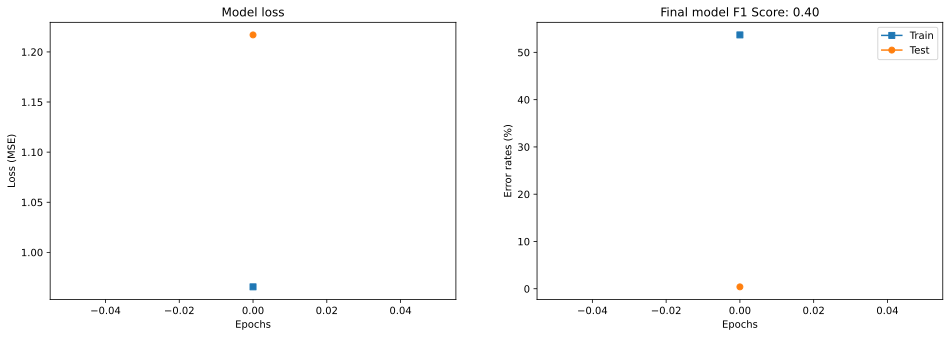

In [30]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainF1,'s-',label='Train')
ax[1].plot(testF1,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model F1 Score: {testF1[-1]:.2f}')
ax[1].legend()

plt.show()

In [31]:
net.eval()
all_predictions = []

# Initialize task counters
task_counters = {task: 0 for task in DATASETS}
global_id = 0

with torch.no_grad(), torch.cuda.amp.autocast():  # Enable AMP for faster inference
    for X, y, task_ids in test_loader:
        X = X.to(device)
        task_ids = task_ids.cpu().numpy()

        # Get unique tasks in this batch
        unique_tasks = np.unique(task_ids)

        # Process each task group in the batch
        for task_idx in unique_tasks:
            task_name = DATASETS[task_idx]
            mask = task_ids == task_idx

            if mask.any():
                task_images = X[mask]
                task_images = task_images.to(device)

                task_image_ids = torch.full((len(task_images),), task_idx)
                task_image_ids = task_image_ids.to(device)

                # Process all images for this task at once
                outputs = net(task_images, task_image_ids)
                preds = outputs.argmax(dim=1).cpu().numpy()

                # Add predictions for this task group
                n_preds = len(preds)
                task_start_idx = task_counters[task_name]

                # Batch create predictions
                batch_predictions = [{
                    'id': global_id + i,
                    'label': int(pred),
                    'task_name': task_name,
                    'id_image_in_task': task_start_idx + i
                } for i, pred in enumerate(preds)]

                all_predictions.extend(batch_predictions)

                # Update counters
                task_counters[task_name] += n_preds
                global_id += n_preds
        msg = f'Finished test set {len(all_predictions)}'
        sys.stdout.write('\r' + msg)

# Create DataFrame and save
df = pd.DataFrame(all_predictions)
df = df[['id', 'label', 'task_name', 'id_image_in_task']]
df.to_csv('submission.csv', index=False)

print(f"\nSubmission saved with {len(df)} total predictions")
df.head()

<ipython-input-31-531a673052a8>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():  # Enable AMP for faster inference


Finished test set 96941
Submission saved with 96941 total predictions


,id,label,task_name,id_image_in_task
0,0,8,pathmnist,0
1,1,4,pathmnist,1
2,2,1,pathmnist,2
3,3,2,pathmnist,3
4,4,4,pathmnist,4
